In [1340]:
import numpy as np
import warnings
from scipy.stats import zscore
from scipy.special import expit
import networkx as nx
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
import itertools
import matplotlib.pyplot as plt
#%run load_nc_and_subset.ipynb
#%matplotlib notebook
%matplotlib inline

In [909]:
def get_cross_entropy(p, y):
    p, y = np.squeeze(p), np.squeeze(y)
    return (-1/y.shape[0]) * np.sum(y*np.log(p+1E-6) + (1-y)*np.log(1-p+1E-6))

def get_mean_squared_error(p, y):
    p, y = np.squeeze(p), np.squeeze(y)
    return (1/y.shape[0]) * np.sum((y-p)**2)

def get_r_squared_score(p, y):
    p, y = np.squeeze(p), np.squeeze(y)
    yb = np.sum(y)/y.shape[0]
    sstot = np.sum((y-yb)**2)
    ssres = np.sum((y-p)**2)
    return 1 - ssres/sstot

# Validate custom MSE and R2 computation functions
np.random.seed(0)
tp, ty = np.random.rand(10), np.random.rand(10)
assert(mean_squared_error(tp, ty)==get_mean_squared_error(tp, ty)), 'MSE does not match ground truth!'
assert(get_r_squared_score(tp, ty)==r2_score(ty, tp)), 'R2 does not match ground truth!'

# Neural Network

**Note**: gradient descent was implemented following [this guide](https://towardsdatascience.com/a-step-by-step-implementation-of-gradient-descent-and-backpropagation-d58bda486110) by Yitong Ren of Towards Data Science.

In [910]:
class Node:
    def __init__(self, activation_function=np.sign, coalescant_function=np.sum):
        self._coalescant_function = coalescant_function
        self._weight = 1
        self._activation_function = activation_function
        
    def __str__(self):
        return '[{} {} {}]'.format(
            self._coalescant_function.__name__, 
            self._weight, 
            self._activation_function.__name__
        )
    
    @property 
    def activation(self):
        return self._activation_function
    
    @property 
    def coalescant(self):
        return self._coalescant_function
    
    def propagate(self, tensor):
        return self.activation(
            self._weight * self.coalescant(tensor)
        ) 
    
class Layer:
    def __init__(self, network=None, nodes=0):
        self._nodes = {idx:Node() for idx in range(nodes)}
        self._network = network
        self._upstream = None
        self._downstream = None
    
    @property
    def node_keys(self):
        return list(self._nodes.keys())

    @property
    def nodes(self):
        return list(self._nodes.items())
    
    @property
    def downstream_nodes(self):
        return self.downstream.node_keys if self.downstream else None
    
    @property
    def upstream_nodes(self):
        return self.upstream.node_keys if self.upstream else None
    
    @property
    def downstream(self):
        return self._downstream
    
    @property
    def upstream(self):
        return self._upstream
    
    def build_connectivity(self):
        if self.upstream is None:
            connections= []
        else:
            connections = list(itertools.product(self.upstream_nodes,self.node_keys))
        return self.node_keys, connections
    

def keygen(layer, node, **kwargs):
    return 'layer{}:node{}'.format(layer,node)
    
class NeuralNetwork:
    def __init__(self, input_layer=None, output_layer=None):
        self._input_layer  = input_layer
        self._output_layer = output_layer
        self._layers = []
        self._weights = []
        self._connectivity = None
    
    @property
    def layers(self):
        return self._layers
    
    def add_layer(self, layer):
        layer.network = self
        self._layers.append(layer)
        
    def build_connectivity(self):
        self._weights = []
        self._connectivity = nx.Graph()
        all_layers = [self._input_layer] + self._layers + [self._output_layer]
        for idx, layer in enumerate(all_layers):
            layer._upstream = None if idx == 0 else all_layers[idx-1]
            layer._downstream = all_layers[idx+1] if idx+1 < len(all_layers) else None 
            if layer._upstream is not None:
                sx, sy = len(layer._upstream.node_keys), len(layer.node_keys)
                self._weights.append(
                    np.zeros((sx, sy))
                )
            nodes, connections = layer.build_connectivity()
            nodes = [keygen(idx,node) for node in nodes]
            connections = [(keygen(idx-1, nu), keygen(idx, nd)) for nu, nd in connections]
            self._connectivity.add_edges_from(connections)
        self._all_layers = all_layers
    
    def visualize(self):
        pos = {}
        for idx, layer in enumerate(self._all_layers):
            length = len(layer.nodes)
            y = np.arange(-length/2,length/2,1)            
            pos.update({keygen(idx,node):(idx,y[node]) for node in layer.node_keys})
        nx.draw(self._connectivity, pos=pos)
        plt.show()
    
    def initialize(self, seed=0):
        np.random.seed(seed)
        self.build_connectivity()
        for idx in range(len(self._weights)):
            self._weights[idx] = np.random.rand(*self._weights[idx].shape)
    
    def predict(self, X, return_partials=False):
        x = X
        Lx = []
        for w in self._weights:
            Lx.append(x)
            x = sigmoid(x, w)
            y_out = x
        if return_partials:
            return Lx, y_out
        else:
            return np.squeeze(y_out)
    
    def classify(self, X):
        y_out = self.predict(X)
        if y_out.ndim == 1 or y_out.shape[-1] == 1:
            classifications = np.round(np.clip(y_out,0,1)) 
        else:
            classifications = np.argmax(y_out,axis=1)
        return np.squeeze(classifications)
    
    def score(self, X, y):
        y = np.squeeze(y)
        if y.ndim == 2:
            y = np.argmax(y,axis=1)
        return np.sum(
            np.squeeze(self.classify(X))==y
        )/y.shape[0]
    
    def gradient_descent(self, X, y, iterations):
        if y.ndim == 1:
            y = y.reshape((-1,1))
        
        wlid = np.identity(y.shape[-1])
        scores = np.zeros((iterations,))
        
        for i in range(iterations):
            Lx, y_out = self.predict(X, return_partials=True)
            
            lg = (y - y_out)
            wl = wlid
            Lgrad = []
            
            for idx, (lx, w) in enumerate(zip(Lx[::-1], self._weights[::-1])):
                delta = np.dot(lg, wl.T)
                lg = delta * sigmoid_derivative(lx, w)
                grad = np.dot(lx.T, lg)
                wl = w
                Lgrad.append(grad)
            
            for idx in range(len(self._weights)):
                self._weights[idx] = self._weights[idx] + Lgrad[-(idx+1)]
            
            scores[i] = self.score(X,y)
        return scores
    
def sigmoid(x, w):
    return expit(np.dot(x, w))

def sigmoid_derivative(x, w):
    return sigmoid(x, w) * (1 - sigmoid(x, w))


# Verify Basic Operation

In [911]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
N = 100
M = 5
E = 10000

X, y_i = make_classification(
    n_samples=N, 
    n_features=M, 
    n_informative=M,
    n_redundant=0,
    n_classes=M, 
    random_state=1
)

y = np.zeros((M, N))
np.put_along_axis(y, y_i[np.newaxis, :], np.ones((N,)), axis=0)
y = y.T.reshape(N,M)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

clf = MLPClassifier(
    solver='sgd',
    random_state=0,
    max_iter=E
)
clf.fit(X_train, y_train)
clf.predict_proba(X_test[:1])
print(clf.score(X_test, y_test))
default_params = clf.get_params()

0.48


<IPython.core.display.Javascript object>


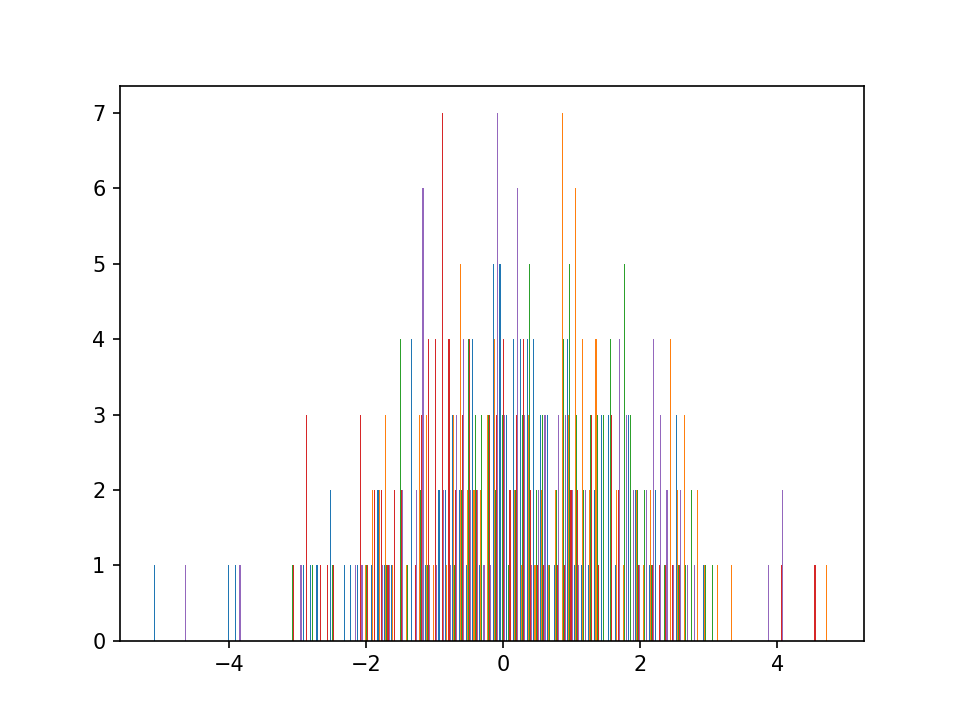

In [912]:
plt.figure()
plt.hist(X, bins=100);

In [913]:
nn = NeuralNetwork(
    input_layer = Layer(nodes=(1 if (X.ndim == 1) else X.shape[-1])),
    output_layer = Layer(nodes=(1 if (y.ndim == 1) else y.shape[-1]))
)
layers = []
for s in (10,):
    layer = Layer(nodes=s)
    nn.add_layer(layer)
    layers.append(s)
nn.initialize()
mse = nn.gradient_descent(
    X, 
    y, 
    E
)
print(nn.score(X, y))
# print(list(zip(*np.unique(y_p, return_counts=True))))
# tp = np.sum(y[y_p==1])*100/y.shape[0]
# fp = np.sum(y_p[y==0])*100/y.shape[0]
# tn = (np.sum(np.logical_not(y[y_p==0])))*100/y.shape[0]
# fn = (np.sum(np.logical_not(y_p[y==1])))*100/y.shape[0]
# print('True Positive: {:.2f} False Positive: {:.2f} True Negative: {:.2f} False Negative: {:.2f}'.format(tp,fp,tn,fn))

0.6


<IPython.core.display.Javascript object>


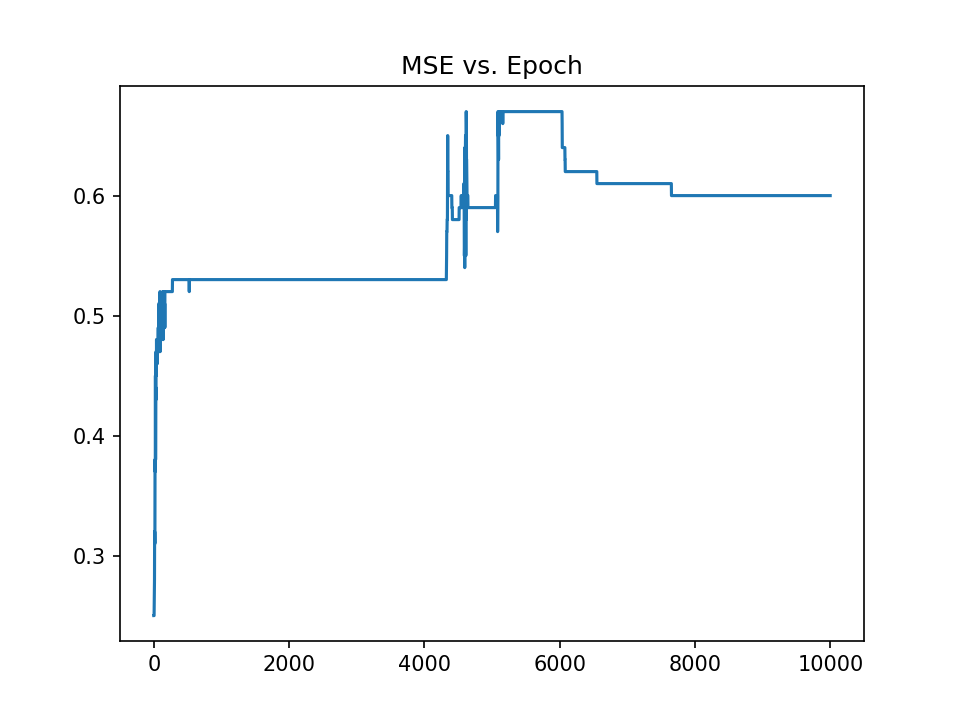

Text(0.5, 1.0, 'MSE vs. Epoch')

In [914]:
Np = 10000
idx = np.arange(0,E,np.ceil(1+E/Np)).astype(int)
plt.figure()
plt.plot(idx, mse[idx])
plt.title('MSE vs. Epoch')

# Generate Experiment Data

In [1284]:
N = 1000
M = 5
E = 1000

np.random.seed(0)

nonnan = ~np.isnan(usdm)

valid_spi  =  spi[nonnan]
valid_sesr = sesr[nonnan]
valid_usdm = usdm[nonnan]

random_slices = np.zeros((N,3))
for i in range(N):
    random_slices[i,:] = [np.random.choice(r).astype(int) for r in [np.arange(20,90), np.arange(35,75), np.arange(0,500)]]

X_l = np.zeros((N,10))
y_l = np.zeros((N))

im = np.all(nonnan,axis=2).astype(float)

def subset(x,y,v1,v2):
    return [
        v1[x-1,y  ], 
        v1[x  ,y  ], 
        v1[x+1,y  ],
        v1[x  ,y-1],
        v1[x  ,y+1],
        v2[x-1,y  ], 
        v2[x  ,y  ], 
        v2[x+1,y  ],
        v2[x  ,y-1],
        v2[x  ,y+1]
    ]

for i, (y, x, z) in enumerate(random_slices.astype(int)):
    X_l[i,:] = subset(x,y,spi[:, :, z],sesr[:, :, z])
    y_l[i] = usdm[x, y, z] > 0 
    im[x,y] = z   
im[im==0] = np.nan

u_idx_l = np.random.choice(X_l.shape[0], X_l.shape[0], replace=False)
testing_u_i = np.random.choice(u_idx_l, size=int(u_idx_l.size*0.20), replace=False)
u_idx_l = np.setdiff1d(u_idx_l, testing_i)
training_u_i = np.random.choice(u_idx_l, size=int(u_idx_l.size*0.75), replace=False)
validation_u_i = np.setdiff1d(u_idx_l, training_i)

testing_s    = np.copy(X_l[:,[1,6]][testing_u_i,:]), y_l[testing_u_i]
training_s   = np.copy(X_l[:,[1,6]][training_u_i,:]), y_l[training_u_i]
validation_s = np.copy(X_l[:,[1,6]][validation_u_i,:]), y_l[validation_u_i]

testing_u    = np.copy(X_l[testing_u_i,:]), y_l[testing_u_i]
training_u   = np.copy(X_l[training_u_i,:]), y_l[training_u_i]
validation_u = np.copy(X_l[validation_u_i,:]), y_l[validation_u_i]

## Sample Region with Random Points

<IPython.core.display.Javascript object>


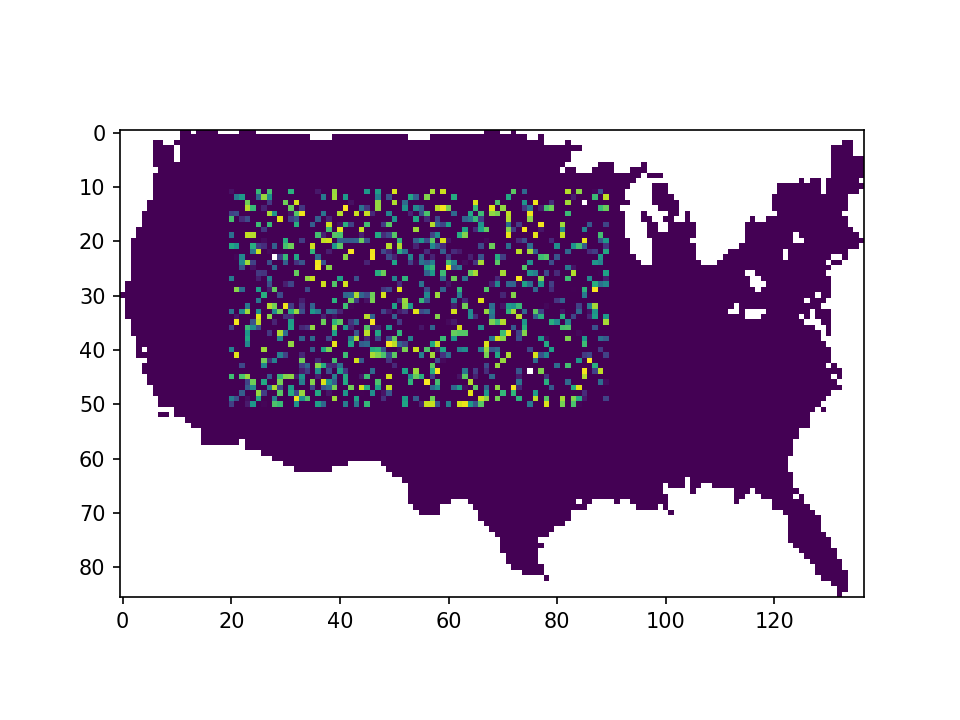

In [1138]:
plt.figure()
plt.imshow(im[::-1,:]);

## Histogram of Experimental X

<IPython.core.display.Javascript object>


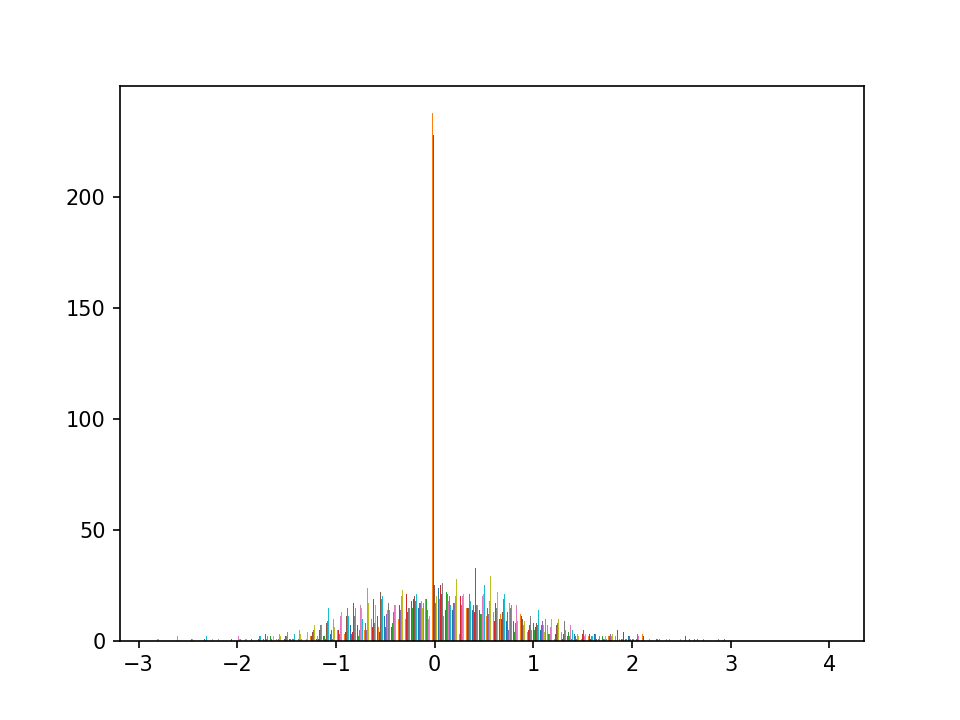

In [1299]:
plt.figure()
plt.hist(training_u[0], bins=100);

# Run Experiments Using Only Points

In [1300]:
clf = MLPClassifier(
    solver='sgd',
    random_state=0
)
X, y = training_s
clf.fit(X, y)
y_p = clf.predict(X)
print('Validation score: {:.2f}%'.format(100*clf.score(X,y)))
tp = np.sum(y[y_p==1])*100/y.shape[0]
fp = np.sum(y_p[y==0])*100/y.shape[0]
tn = (np.sum(np.logical_not(y[y_p==0])))*100/y.shape[0]
fn = (np.sum(np.logical_not(y_p[y==1])))*100/y.shape[0]
print('  True Positive: {:5.2f} False Positive: {:5.2f}\n  True Negative: {:5.2f} False Negative: {:5.2f}'.format(tp,fp,tn,fn))

Validation score: 69.41%
  True Positive:  7.73 False Positive:  4.11
  True Negative: 61.68 False Negative: 26.48


In [1337]:
# Use hidden layer size predicted generated by scikit learn
layer_sizes = (12,)
E = 100000
nn = NeuralNetwork(
    input_layer = Layer(nodes=2),
    output_layer = Layer(nodes=1)
)
layers = []
for s in layer_sizes:
    layer = Layer(nodes=s)
    nn.add_layer(layer)
    layers.append(s)
nn.initialize()

X, y = testing_s
accuracy = nn.gradient_descent(X, y, E)
y_p = nn.classify(X)
print('Training score: {:.2f}%'.format(100*nn.score(X,y)))

X, y = validation_s
y_p = nn.classify(X)
print('Validation score: {:.2f}%'.format(100*nn.score(X,y)))
tp = np.sum(y[y_p==1])*100/y.shape[0]
fp = np.sum(y_p[y==0])*100/y.shape[0]
tn = (np.sum(np.logical_not(y[y_p==0])))*100/y.shape[0]
fn = (np.sum(np.logical_not(y_p[y==1])))*100/y.shape[0]
print('  True Positive: {:5.2f} False Positive: {:5.2f}\n  True Negative: {:5.2f} False Negative: {:5.2f}'.format(tp,fp,tn,fn))

Training score: 67.50%
Validation score: 72.20%
  True Positive: 15.61 False Positive: 10.24
  True Negative: 56.59 False Negative: 17.56


<IPython.core.display.Javascript object>


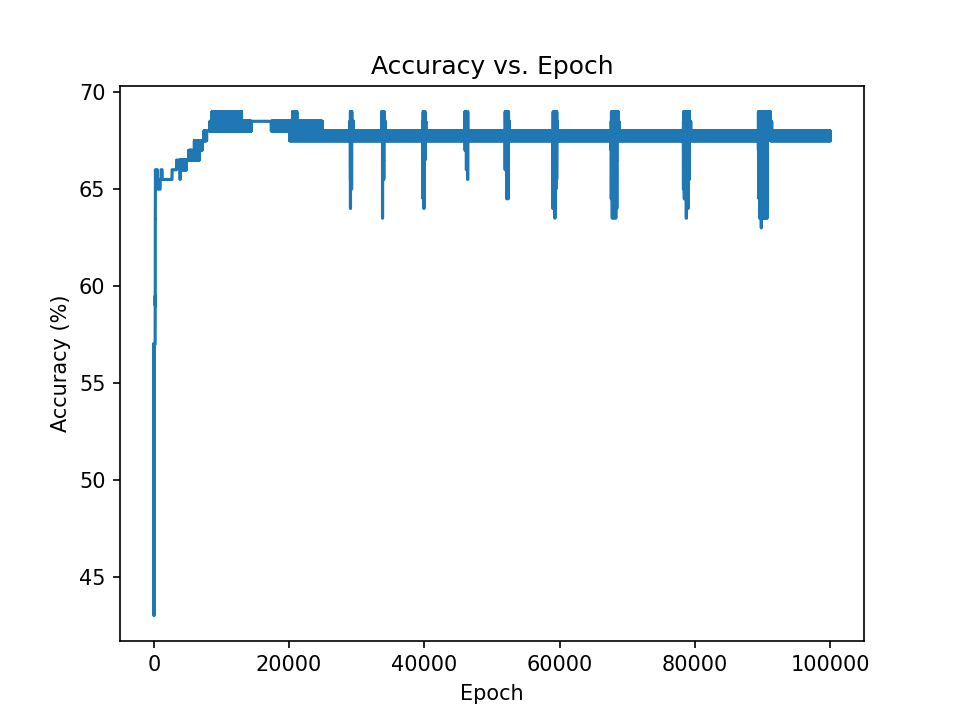

In [1338]:
plt.figure()
plt.plot(accuracy*100)
plt.title('Accuracy vs. Epoch')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.show()

# Run Experiment Using Points and Four Nearest Neighbors

<IPython.core.display.Javascript object>


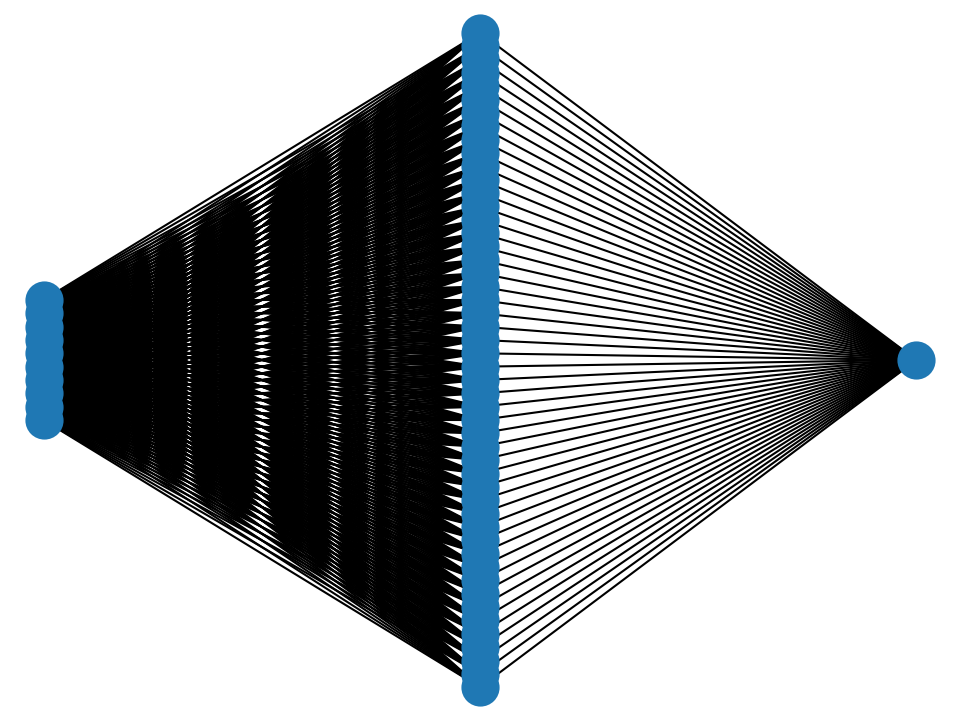

Training score: 90.46%


In [1195]:
# Use hidden layer size predicted generated by scikit learn
layer_sizes = (50,)
E = 100000
nn = NeuralNetwork(
    input_layer = Layer(nodes=10),
    output_layer = Layer(nodes=1)
)
layers = []
for s in layer_sizes:
    layer = Layer(nodes=s)
    nn.add_layer(layer)
    layers.append(s)
nn.initialize()
plt.figure()
nn.visualize()

X,y = training_u
accuracy = nn.gradient_descent(X, y, E)
print('Training score: {:.2f}%'.format(100*nn.score(X,y)))

In [1196]:
X,y = validation_u
y_p = nn.classify(X)
print('Validation score: {:.2f}%'.format(100*nn.score(X,y)))
tp = np.sum(y[y_p==1])*100/y.shape[0]
fp = np.sum(y_p[y==0])*100/y.shape[0]
tn = (np.sum(np.logical_not(y[y_p==0])))*100/y.shape[0]
fn = (np.sum(np.logical_not(y_p[y==1])))*100/y.shape[0]
print('  True Positive: {:5.2f} False Positive: {:5.2f}\n  True Negative: {:5.2f} False Negative: {:5.2f}'.format(tp,fp,tn,fn))

Validation score: 88.29%
  True Positive: 23.41 False Positive:  1.95
  True Negative: 64.88 False Negative:  9.76


<IPython.core.display.Javascript object>


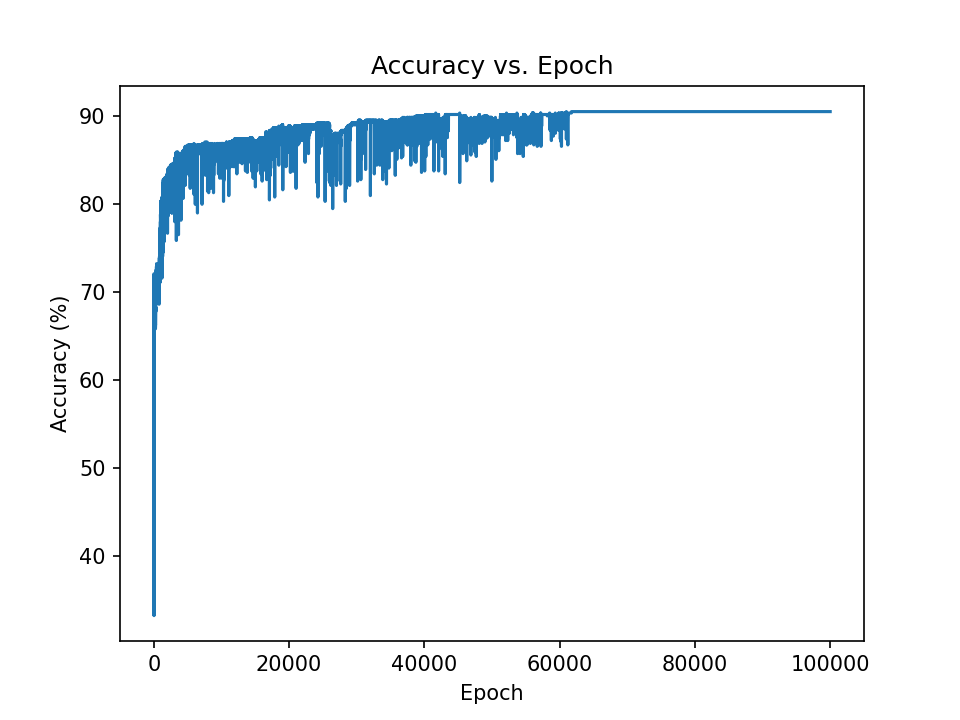

In [1203]:
plt.figure()
plt.plot(accuracy*100)
plt.title('Accuracy vs. Epoch')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.show()